In [1]:
# Import required libraries
# Add whatever you want
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# Test tensorflow
print('TensorFlow version: ' + tf.__version__)
a = tf.constant(2.0)
b = tf.constant(3.0)
c = a * b

sess = tf.Session()
result = sess.run([a, b, c])
print('%f * %f = %f' % (result[0], result[1], result[2]))
sess.close()

# load data
TRAIN_FOLDER = '../data/normalized/train'
TEST_FOLDER = '../data/normalized/test'
ID_FILE = '../data/normalized/id.json'
NUM_SPEAKERS = 200

def get_attributes(fname):
    attr = fname.split('.')[0].split('-')
    dialect = attr[0]
    gender = attr[1][0]
    speaker_id = attr[1]
    sentence_type = attr[2][:2]
    return dialect, gender, speaker_id, sentence_type

def load_files(train):
    X = []
    Y = []
    for speaker_id, flist in train.items():
        for fname in flist:
            filedata = np.load(fname)
            for segment in filedata:
                for x in segment:
                    X.append(x) # dim(x) => (390,)
                    Y.append(speaker_id)
    return X, Y
    

def load_train_data():
    import json
    with open(ID_FILE, 'r') as f_json:
        ids = json.load(f_json)
    print('ids', ids)
    
    
    files = [f for f in os.listdir(TRAIN_FOLDER) if os.path.isfile(os.path.join(TRAIN_FOLDER, f))]

    # split train val data
    train = {}
    val = {}
    
    added = {}
    for file in files:
        dialect, gender, speaker_id, sentence_type = get_attributes(file)
        file_path = os.path.join(TRAIN_FOLDER, file)
        if speaker_id not in ids:
            print('ERROR:', speaker_id, 'not found in ids')
        speaker_id = ids[speaker_id]
        val_set = added.setdefault(speaker_id, {})
        if sentence_type not in val_set:
            val.setdefault(speaker_id, []).append(file_path)
            val_set[sentence_type] = True
        else:
            train.setdefault(speaker_id, []).append(file_path)
    # test data    
    test = {}
    files = [f for f in os.listdir(TEST_FOLDER) if os.path.isfile(os.path.join(TEST_FOLDER, f))]
    for file in files:
        dialect, gender, speaker_id, sentence_type = get_attributes(file)
        file_path = os.path.join(TEST_FOLDER, file)
        if speaker_id not in ids:
            print('ERROR:', speaker_id, 'not found in ids')
        speaker_id = ids[speaker_id]
        test.setdefault(speaker_id, []).append(file_path)
    
    # load data
    # input_path = os.path.join(TRAIN_FOLDER, file)
    X_train, Y_train = load_files(train)
    X_val, Y_val = load_files(val)
    X_test, Y_test = load_files(test)
    return np.array(X_train), np.array(Y_train), np.array(X_val), np.array(Y_val), np.array(X_test), np.array(Y_test)
    
print('Loading data...')
X_train, Y_train, X_val, Y_val, X_test, Y_test = load_train_data()

print()
print('# Train :', len(Y_train))
print('# Eval  :', len(Y_val))
print('# Test  :', len(Y_test))
print()

# model
def fully_connected(input, num_outputs, act_fn=None):
    return tf.contrib.layers.fully_connected(input, num_outputs,
                                             activation_fn=act_fn,
                                             weights_initializer=tf.random_normal_initializer(0.0, 0.02),
                                             weights_regularizer=tf.contrib.layers.l2_regularizer(scale=0.0001)
                                            )

class BaseModel(object):
    def __init__(self):
        self.batch_size = 128
        self.log_step = 50
        self._build_model()

    def _model(self):
        print('-' * 5 + '  Sample model  ' + '-' * 5)

        print('input layer: ' + str(self.X.get_shape()))

        with tf.variable_scope('fc1'):
            
            self.fc1 = fully_connected(self.X, 390)
            self.relu1 = tf.nn.relu(self.fc1)
            
            print('fc1 layer: ' + str(self.relu1.get_shape()))

        with tf.variable_scope('fc2'):
            
            self.fc2 = fully_connected(self.relu1, 200)
            self.relu2 = tf.nn.relu(self.fc2)
            
            print('fc2 layer: ' + str(self.relu2.get_shape()))
            
        with tf.variable_scope('fc3'):
            
            self.fc3 = fully_connected(self.relu2, 200)
            
            print('fc3 layer: ' + str(self.fc3.get_shape()))
        
        # Return the last layer
        return self.fc3

    def _input_ops(self):
        # Placeholders
        self.X = tf.placeholder(tf.float32, [None, 390])
        self.Y = tf.placeholder(tf.int64, [None])
        
        self.global_step = tf.Variable(0, trainable=False)
        self.starter_learning_rate = 1e-4
        
        # tf.train.exponential_decay(learning_rate, global_step, decay_steps, 
        # decay_rate, staircase=False, name=None)
        # staircase: Boolean. If True decay the learning rate at discrete intervals
        
        # decay every 500 steps with a base of 0.96
        self.learning_rate = tf.train.exponential_decay(self.starter_learning_rate,
                                                        self.global_step, 500, 0.96,
                                                        staircase=True)
        

    def _build_optimizer(self):
        # Adam optimizer 'self.train_op' that minimizes 'self.loss_op'
        
        # Passing global_step to minimize() will increment it at each step.
        optimizer = tf.train.AdamOptimizer(self.learning_rate)
        self.train_op = optimizer.minimize(self.loss_op, global_step=self.global_step)
        
        
    def _loss(self, labels, logits):
        # Softmax cross entropy loss 'self.loss_op'
        
        loss = tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=logits)
        self.loss_op = tf.reduce_mean(loss)     
        

    def _build_model(self):
        # Define input variables
        self._input_ops()

        # Convert Y to one-hot vector
        labels = tf.one_hot(self.Y, NUM_SPEAKERS)

        # Build a model and get logits
        logits = self._model()

        # Compute loss
        self._loss(labels, logits)
        
        # Build optimizer
        self._build_optimizer()

        # Compute accuracy
        predict = tf.argmax(logits, 1)
        correct = tf.equal(predict, self.Y)
        self.accuracy_op = tf.reduce_mean(tf.cast(correct, tf.float32))
        
    def train(self, sess, X_train, Y_train, X_val, Y_val, num_epoch=40):
        # shuffle
        from sklearn.utils import shuffle
        X_train, Y_train = shuffle(X_train, Y_train)
        
        # try loading checkpoint
        saver = tf.train.Saver()
        save_dir = "tf_models/"        
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        save_path = os.path.join(save_dir, 'csci-599_proj')
        
        try:
            print("Trying to restore last checkpoint ...")

            # Use TensorFlow to find the latest checkpoint - if any.
            last_chk_path = tf.train.latest_checkpoint(checkpoint_dir=save_dir)

            # Try and load the data in the checkpoint.
            saver.restore(sess, save_path=last_chk_path)

            # If we get to this point, the checkpoint was successfully loaded.
            print("Restored checkpoint from:", last_chk_path)
        except:
            # If the above failed for some reason, simply
            # initialize all the variables for the TensorFlow graph.
            print("Failed to restore checkpoint. Initializing variables instead.")
            sess.run(tf.global_variables_initializer())

        step = 0
        losses = []
        accuracies = []
        num_training = len(Y_train)
        print('-' * 5 + '  Start training  ' + '-' * 5)
        for epoch in range(num_epoch):
            print('train for epoch %d' % epoch)
            print('global step: %d' % self.global_step.eval())
            for i in range(num_training // self.batch_size):
                X_ = X_train[i * self.batch_size:(i + 1) * self.batch_size][:]
                Y_ = Y_train[i * self.batch_size:(i + 1) * self.batch_size]
                
                feed_dict = {
                    self.X: X_,
                    self.Y: Y_
                }                
                
                fetches = [self.train_op, self.loss_op, self.accuracy_op]

                _, loss, accuracy = sess.run(fetches, feed_dict=feed_dict)
                losses.append(loss)
                accuracies.append(accuracy)

                if step % self.log_step == 0:
                    print('iteration (%d): loss = %.3f, accuracy = %.3f' %
                        (step, loss, accuracy))
                step += 1
            
            # save state
            model_path = saver.save(sess,
                       save_path=save_path,
                       global_step=self.global_step)
            print("Model saved in %s" % model_path)

            #############################################################################
            # TODO: Plot training curves                                                #
            #############################################################################
            # Graph 1. X: epoch, Y: training loss
            plt.plot(losses)
            plt.title('training loss')
            plt.xlabel('iteration')
            plt.ylabel('loss')
            plt.show()    

            # Graph 2. X: epoch, Y: training accuracy
            plt.plot(accuracies)
            plt.title('training accuracy')
            plt.xlabel('iteration')
            plt.ylabel('accuracy')
            plt.show()

            # Print validation results
            print('validation for epoch %d' % epoch)
            val_accuracy = self.evaluate(sess, X_val, Y_val)
            print('-  epoch %d: validation accuracy = %.3f' % (epoch, val_accuracy))

    def evaluate(self, sess, X_eval, Y_eval):
        eval_accuracy = 0.0
        eval_iter = 0
        for i in range(X_eval.shape[0] // self.batch_size):
            X_ = X_eval[i * self.batch_size:(i + 1) * self.batch_size][:]
            Y_ = Y_eval[i * self.batch_size:(i + 1) * self.batch_size]
                        
            
            feed_dict = {
                    self.X: X_,
                    self.Y: Y_
                }
            
            accuracy = sess.run(self.accuracy_op, feed_dict=feed_dict)
            eval_accuracy += accuracy
            eval_iter += 1
        return eval_accuracy / eval_iter


TensorFlow version: 1.3.1
2.000000 * 3.000000 = 6.000000
Loading data...
ids {'MMDM1': 170, 'MJXL0': 142, 'MMGG0': 175, 'MAFM0': 5, 'MLSH0': 161, 'MKAG0': 143, 'MPGH0': 192, 'MMCC0': 166, 'MJRP0': 136, 'MPEB0': 190, 'MDSS0': 64, 'MEDR0': 71, 'MCEF0': 27, 'MJWG0': 138, 'MDCD0': 41, 'MDCM0': 42, 'MMAA0': 162, 'MMJB1': 177, 'MJDA0': 108, 'MDWH0': 68, 'MDRD0': 62, 'MDJM0': 48, 'MKLS1': 152, 'MDBB1': 39, 'MMPM0': 179, 'MHRM0': 101, 'MMDB0': 167, 'MJLB0': 123, 'MEJS0': 75, 'MFXV0': 84, 'MAJP0': 6, 'MCSS0': 34, 'MBJV0': 16, 'MCTM0': 36, 'MJMM0': 127, 'MESJ0': 77, 'MMVP0': 182, 'MBOM0': 20, 'MKLR0': 151, 'MADD0': 2, 'MGAF0': 85, 'MCAE0': 22, 'MMWS0': 184, 'MNTW0': 188, 'MFER0': 79, 'MDAS0': 38, 'MESG0': 76, 'MDLB0': 50, 'MDLH0': 54, 'MDNS0': 59, 'MDBP0': 40, 'MMEB0': 173, 'MMAM0': 164, 'MCHL0': 29, 'MDDC0': 43, 'MILB0': 103, 'MFRM0': 81, 'MDEM0': 46, 'MHJB0': 98, 'MDED0': 44, 'MPPC0': 196, 'MJXA0': 141, 'MGSL0': 94, 'MKAJ0': 145, 'MDSJ0': 63, 'MJEB1': 114, 'MDSS1': 65, 'MCDR0': 26, 'MPRK0': 19

2017-11-09 01:25:09.489120

-----  Sample model  -----
input layer: (?, 390)
fc1 layer: (?, 390)
fc2 layer: (?, 200)
fc3 layer: (?, 200)
Trying to restore last checkpoint ...
INFO:tensorflow:Restoring parameters from tf_models/csci-599_proj-15540


INFO:tensorflow:Restoring parameters from tf_models/csci-599_proj-15540


Restored checkpoint from: tf_models/csci-599_proj-15540
-----  Start training  -----
train for epoch 0
global step: 15540
iteration (0): loss = 0.928, accuracy = 0.742
iteration (50): loss = 0.975, accuracy = 0.766
iteration (100): loss = 0.883, accuracy = 0.805
iteration (150): loss = 0.831, accuracy = 0.812
iteration (200): loss = 0.877, accuracy = 0.789
iteration (250): loss = 1.016, accuracy = 0.758
iteration (300): loss = 0.911, accuracy = 0.766
iteration (350): loss = 0.980, accuracy = 0.766
iteration (400): loss = 1.140, accuracy = 0.703
iteration (450): loss = 1.090, accuracy = 0.711
iteration (500): loss = 0.929, accuracy = 0.797
Model saved in tf_models/csci-599_proj-16058


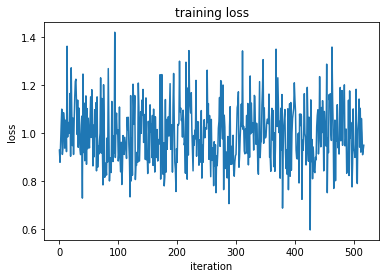

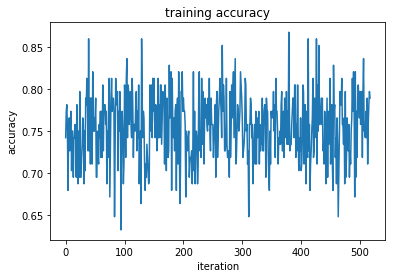

validation for epoch 0
-  epoch 0: validation accuracy = 0.392
train for epoch 1
global step: 16058
iteration (550): loss = 0.926, accuracy = 0.758
iteration (600): loss = 0.880, accuracy = 0.789
iteration (650): loss = 0.916, accuracy = 0.773
iteration (700): loss = 1.047, accuracy = 0.758
iteration (750): loss = 1.214, accuracy = 0.742
iteration (800): loss = 0.850, accuracy = 0.797
iteration (850): loss = 1.145, accuracy = 0.742
iteration (900): loss = 1.058, accuracy = 0.734
iteration (950): loss = 0.883, accuracy = 0.773
iteration (1000): loss = 1.091, accuracy = 0.703
Model saved in tf_models/csci-599_proj-16576


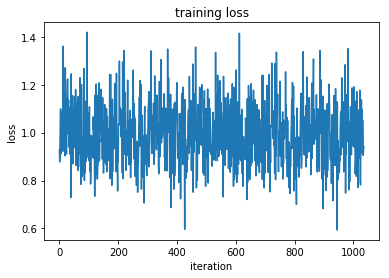

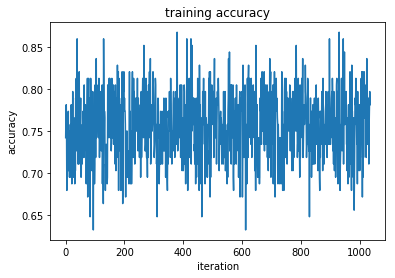

validation for epoch 1
-  epoch 1: validation accuracy = 0.393
train for epoch 2
global step: 16576
iteration (1050): loss = 0.918, accuracy = 0.758
iteration (1100): loss = 1.137, accuracy = 0.742
iteration (1150): loss = 0.884, accuracy = 0.789
iteration (1200): loss = 0.956, accuracy = 0.773
iteration (1250): loss = 0.827, accuracy = 0.734
iteration (1300): loss = 0.854, accuracy = 0.766
iteration (1350): loss = 0.910, accuracy = 0.797
iteration (1400): loss = 0.852, accuracy = 0.758
iteration (1450): loss = 0.917, accuracy = 0.758
iteration (1500): loss = 1.138, accuracy = 0.703
iteration (1550): loss = 0.990, accuracy = 0.766
Model saved in tf_models/csci-599_proj-17094


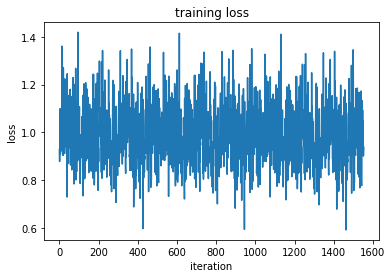

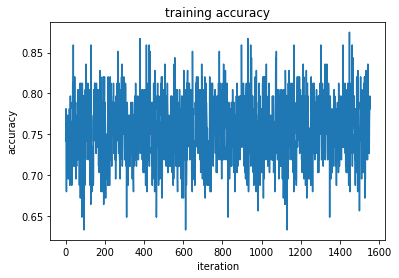

validation for epoch 2
-  epoch 2: validation accuracy = 0.392
train for epoch 3
global step: 17094
iteration (1600): loss = 0.859, accuracy = 0.805
iteration (1650): loss = 1.025, accuracy = 0.742
iteration (1700): loss = 0.876, accuracy = 0.820
iteration (1750): loss = 0.867, accuracy = 0.805
iteration (1800): loss = 1.044, accuracy = 0.727
iteration (1850): loss = 0.832, accuracy = 0.758
iteration (1900): loss = 1.302, accuracy = 0.688
iteration (1950): loss = 1.043, accuracy = 0.711
iteration (2000): loss = 0.983, accuracy = 0.773
iteration (2050): loss = 0.910, accuracy = 0.781
Model saved in tf_models/csci-599_proj-17612


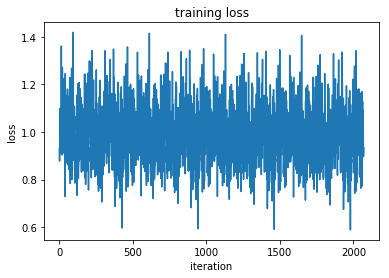

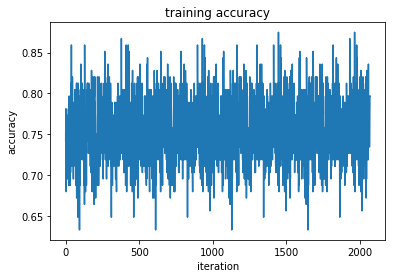

validation for epoch 3
-  epoch 3: validation accuracy = 0.392
train for epoch 4
global step: 17612
iteration (2100): loss = 1.205, accuracy = 0.742
iteration (2150): loss = 0.868, accuracy = 0.766
iteration (2200): loss = 1.133, accuracy = 0.680
iteration (2250): loss = 0.756, accuracy = 0.812
iteration (2300): loss = 0.973, accuracy = 0.727
iteration (2350): loss = 1.181, accuracy = 0.711
iteration (2400): loss = 0.992, accuracy = 0.789
iteration (2450): loss = 1.137, accuracy = 0.742
iteration (2500): loss = 0.869, accuracy = 0.812
iteration (2550): loss = 0.951, accuracy = 0.766
Model saved in tf_models/csci-599_proj-18130


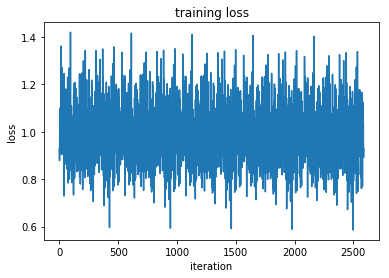

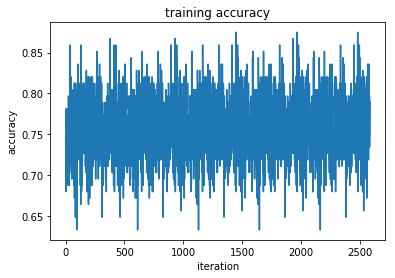

validation for epoch 4
-  epoch 4: validation accuracy = 0.393
train for epoch 5
global step: 18130
iteration (2600): loss = 0.974, accuracy = 0.758
iteration (2650): loss = 1.067, accuracy = 0.719
iteration (2700): loss = 0.887, accuracy = 0.789
iteration (2750): loss = 1.078, accuracy = 0.734
iteration (2800): loss = 1.078, accuracy = 0.695
iteration (2850): loss = 0.916, accuracy = 0.773
iteration (2900): loss = 1.007, accuracy = 0.742
iteration (2950): loss = 1.030, accuracy = 0.750
iteration (3000): loss = 1.059, accuracy = 0.727
iteration (3050): loss = 1.143, accuracy = 0.703
iteration (3100): loss = 0.924, accuracy = 0.773
Model saved in tf_models/csci-599_proj-18648


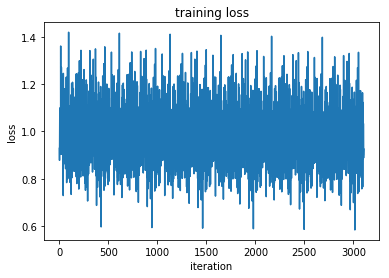

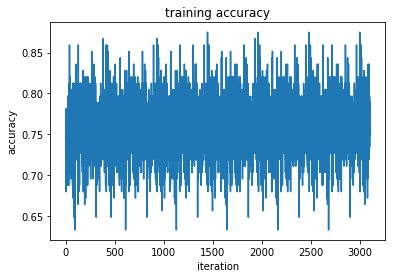

validation for epoch 5
-  epoch 5: validation accuracy = 0.393
train for epoch 6
global step: 18648
iteration (3150): loss = 1.080, accuracy = 0.734
iteration (3200): loss = 0.973, accuracy = 0.797
iteration (3250): loss = 1.161, accuracy = 0.703
iteration (3300): loss = 0.821, accuracy = 0.836
iteration (3350): loss = 0.796, accuracy = 0.797
iteration (3400): loss = 0.927, accuracy = 0.797
iteration (3450): loss = 0.932, accuracy = 0.781
iteration (3500): loss = 0.798, accuracy = 0.750
iteration (3550): loss = 1.213, accuracy = 0.688
iteration (3600): loss = 0.803, accuracy = 0.820
Model saved in tf_models/csci-599_proj-19166


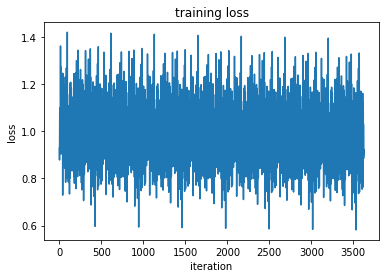

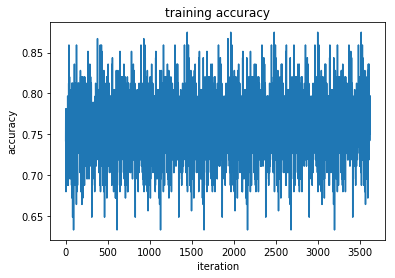

validation for epoch 6
-  epoch 6: validation accuracy = 0.393
train for epoch 7
global step: 19166
iteration (3650): loss = 0.886, accuracy = 0.797
iteration (3700): loss = 0.762, accuracy = 0.805
iteration (3750): loss = 0.792, accuracy = 0.797
iteration (3800): loss = 1.214, accuracy = 0.719
iteration (3850): loss = 1.141, accuracy = 0.680
iteration (3900): loss = 1.185, accuracy = 0.734
iteration (3950): loss = 1.209, accuracy = 0.711
iteration (4000): loss = 1.023, accuracy = 0.742
iteration (4050): loss = 1.048, accuracy = 0.758
iteration (4100): loss = 0.927, accuracy = 0.703
Model saved in tf_models/csci-599_proj-19684


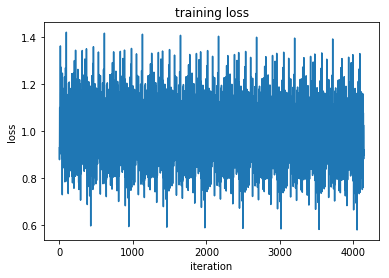

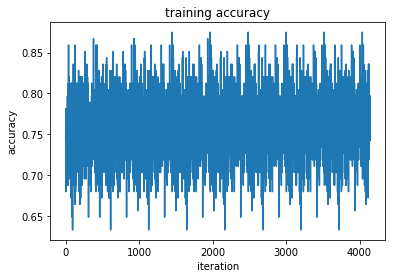

validation for epoch 7
-  epoch 7: validation accuracy = 0.393
train for epoch 8
global step: 19684
iteration (4150): loss = 0.896, accuracy = 0.766
iteration (4200): loss = 1.068, accuracy = 0.727
iteration (4250): loss = 0.751, accuracy = 0.805
iteration (4300): loss = 1.004, accuracy = 0.766
iteration (4350): loss = 1.077, accuracy = 0.727
iteration (4400): loss = 0.914, accuracy = 0.781
iteration (4450): loss = 0.868, accuracy = 0.805
iteration (4500): loss = 1.133, accuracy = 0.719
iteration (4550): loss = 0.977, accuracy = 0.781
iteration (4600): loss = 0.951, accuracy = 0.789
iteration (4650): loss = 0.757, accuracy = 0.836
Model saved in tf_models/csci-599_proj-20202


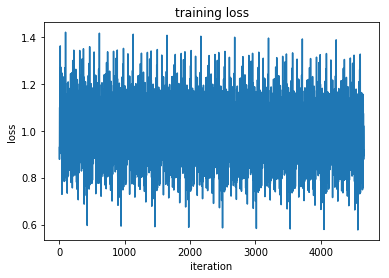

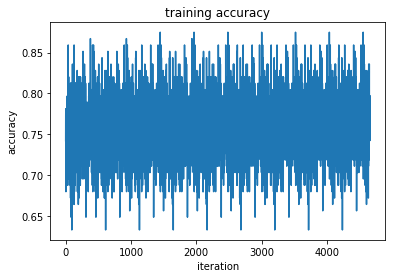

validation for epoch 8
-  epoch 8: validation accuracy = 0.393
train for epoch 9
global step: 20202
iteration (4700): loss = 1.025, accuracy = 0.781
iteration (4750): loss = 0.796, accuracy = 0.805
iteration (4800): loss = 1.041, accuracy = 0.734
iteration (4850): loss = 1.170, accuracy = 0.688
iteration (4900): loss = 0.941, accuracy = 0.781
iteration (4950): loss = 0.679, accuracy = 0.852
iteration (5000): loss = 0.805, accuracy = 0.781
iteration (5050): loss = 1.054, accuracy = 0.750
iteration (5100): loss = 1.046, accuracy = 0.758
iteration (5150): loss = 0.806, accuracy = 0.781
Model saved in tf_models/csci-599_proj-20720


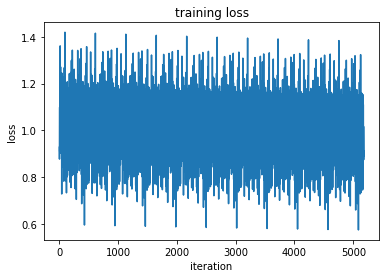

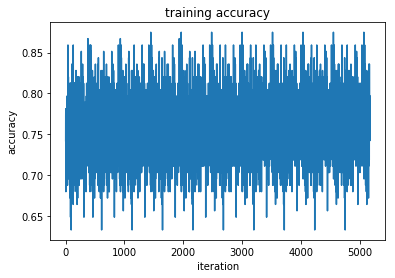

validation for epoch 9
-  epoch 9: validation accuracy = 0.393
***** test accuracy: 0.419
Done
2017-11-09 01:25:54.985368
Total time: 45.49633312225342 seconds


In [2]:
import os
import time
from datetime import datetime

start_time = time.time()
print(datetime.now())
print()

# Clear old computation graphs
tf.reset_default_graph()

# Train our sample model
with tf.Session(config=tf.ConfigProto(
      allow_soft_placement=True)) as sess:
    with tf.device('/gpu:0'):
        model = BaseModel()
        model.train(sess, X_train, Y_train, X_val, Y_val, num_epoch=10)
        accuracy = model.evaluate(sess, X_test, Y_test)
        print('***** test accuracy: %.3f' % accuracy)
        
print('Done')
print(datetime.now())
print("Total time: %s seconds" % (time.time() - start_time))